# Machine Learning hand-in 4
This handin is about implementing and using representative-based clustering algorithms. If you have made your way through the programming exercises for weeks 11 and 12 you are almost done with the first two parts of the handin. 

The handin is mandatory, and should be done in groups of 2-3 students. Each group
must prepare a report in PDF format as outlined below. Please submit all your
Python files in a zip file, and your PDF report outside the zip file, to
Blackboard no later than **Monday, December 10 at 8:00 AM**.

In [113]:
import numpy as np
import math
%matplotlib inline
import matplotlib.pyplot as plt

## 1. Implementing the Algorithms
In this section you must implement Lloyds algorithm andthe Gaussian Mixture Expectation
Maximization algorithm. Please refer to p. 349 and p. 335 of the textbook [ZM] or see the exercises from <a href="https://github.com/AlexanderMath/MLNotebooks/blob/master/AU%20ML%20course/Week%2011.ipynb" target="new">week 11</a>/12. If you already did this during class copy paste them in below. Like in class, you should test your algorithms on the Iris data set:

<!-- 
For the EM algorithm, you may use the `pdf` function below to compute the probability
densities in the Gaussian Mixture model.

You should use the Python code displayed previously to load and display Iris data
and apply PCA to reduce it from four dimensions to two.

Use the 2d Iris data to validate your algorithms (compare the results you get
with the results in the textbook on the same data), and run your algorithms on
the 4d data and compare.

You should read the deliverables section at the very end of the notebook before getting into detail with the code below.-->

In [114]:
# Load the Iris data set
import sklearn.datasets
iris = sklearn.datasets.load_iris()
X = iris['data'][:,0:2] # reduce to 2d so you can plot if you want

### 1.1 Lloyd's Algorithm
You are allowed to structure your code however you want. The template below is identical to the one given in class at <a href="https://github.com/AlexanderMath/MLNotebooks/blob/master/AU%20ML%20course/Week%2011.ipynb" target="new">week 11</a>. We recommend you use it. 

In [115]:
def lloyds_algorithm(X, k, T):
    """ Clusters the data of X into k clusters using T iterations of Lloyd's algorithm. 
    
        Parameters
        ----------
        X : Data matrix of shape (n, d)
        k : Number of clusters.
        T : Maximum number of iterations to run Lloyd's algorithm. 
        
        Returns
        -------
        clustering: A vector of shape (n, ) where the i'th entry holds the cluster of X[i].
        centroids:  The centroids/average points of each cluster. 
        cost:       The cost of the clustering 
    """
    n, d = X.shape
    
    # Initialize clusters random. 
    clustering = np.random.randint(0, k, (n, )) 
    centroids  = np.zeros((k, d))
    
    # Used to stop if cost isn't improving (decreasing)
    cost = 0
    oldcost = 0
    
    # Column names
    #print("Iterations\tCost")
    
    for i in range(T):
       # YOUR CODE HERE
        for j in range(k):
            centroids[j] = X[clustering == j].mean(axis=0)
        # END CODE

        # Update clustering 
        
        # YOUR CODE HERE
        for j in range(n):
            shortest_dist = 0
            shortest_centroid = -1
            for i in range(k):
                dist = (X[j] - centroids[i])**2
                distance = math.sqrt(np.sum(dist))
                if shortest_centroid == -1 or distance < shortest_dist :
                    shortest_centroid = i
                    shortest_dist = distance
            
            clustering[j] = shortest_centroid
            
        # END CODE
        
        # Compute and print cost
        cost = 0
        for j in range(n):
            cost += np.linalg.norm(X[j] - centroids[clustering[j]])**2 
            #   
        #print(i+1, "\t\t", cost)
        
        # Stop if cost didn't improve more than epislon (decrease)
        if np.isclose(cost, oldcost): break #TODO
        oldcost = cost
        
    return clustering, centroids, cost

clustering, centroids, cost = lloyds_algorithm(X, 3, 100)
print(centroids,cost)

[[5.8        2.7       ]
 [5.00392157 3.4       ]
 [6.82391304 3.07826087]] 37.14117220801364


### 1.2 Expectation Maximization Algorithm
Again, you are allowed to structure your code however you want. The template below (and the helper function `compute_probs_cx`) is identical to the one given in class at <a href="https://github.com/AlexanderMath/MLNotebooks/blob/master/AU%20ML%20course/Week-12.ipynb" target="new">week 12</a>. We recommend you use it. 

In [116]:
import numpy as np
from scipy.stats import multivariate_normal

def compute_probs_cx(points, means, covs, probs_c):
    '''
    Input
      - points: (n times d) array containing the dataset
      - means:  (k times d) array containing the k means
      - covs:   (k times d times d) array such that cov[j,:,:] is the covariance matrix of the j-th Gaussian.
      - priors: (k) array containing priors
    Output
      - probs:  (k times n) array such that the entry (i,j) represents Pr(C_i|x_j)
    '''
    # Convert to numpy arrays.
    points, means, covs, probs_c = np.asarray(points), np.asarray(means), np.asarray(covs), np.asarray(probs_c)
    
    # Get sizes
    n, d = points.shape
    k = means.shape[0]
    
    # Compute probabilities
    # This will be a (k, n) matrix where the (i,j)'th entry is Pr(C_i)*Pr(x_j|C_i).
    probs_cx = np.zeros((k, n))
    for i in range(k):
        try:
            probs_cx[i] = probs_c[i] * multivariate_normal.pdf(mean=means[i], cov=covs[i], x=points)
        except Exception as e:
            print("Cov matrix got singular: ", e)
    
    # The sum of the j'th column of this matrix is P(x_j); why?
    probs_x = np.sum(probs_cx, axis=0, keepdims=True) 
    assert probs_x.shape == (1, n)
    
    # Divide the j'th column by P(x_j). The the (i,j)'th then 
    # becomes Pr(C_i)*Pr(x_j)|C_i)/Pr(x_j) = Pr(C_i|x_j)
    probs_cx = probs_cx / probs_x
    
    return probs_cx, probs_x

In [117]:
def em_algorithm(X, k, T, epsilon = 0.001, means=None):
    """ Clusters the data X into k clusters using the Expectation Maximization algorithm. 
    
        Parameters
        ----------
        X : Data matrix of shape (n, d)
        k : Number of clusters.
        T : Maximum number of iterations
        epsilon :  Stopping criteria for the EM algorithm. Stops if the means of
                   two consequtive iterations are less than epsilon.
        means : (k times d) array containing the k initial means (optional)
        
        Returns
        -------
        means:     (k, d) array containing the k means
        covs:      (k, d, d) array such that cov[j,:,:] is the covariance matrix of 
                   the Gaussian of the j-th cluster
        probs_c:   (k, ) containing the probability Pr[C_i] for i=0,...,k. 
        llh:       The log-likelihood of the clustering (this is the objective we want to maximize)
    """
    n, d = X.shape
    
    # Initialize and validate mean
    if means is None: 
        means = np.random.rand(k, d)

    # Initialize cov, prior
    probs_x  = np.zeros(n) 
    probs_cx = np.zeros((k, n)) 
    probs_c  = np.zeros(k) + np.random.rand(k)
    
    covs = np.zeros((k, d, d))
    for i in range(k): covs[i] = np.identity(d)
    probs_c = np.ones(k) / k
    
    # Column names
    #print("Iterations\tLLH")
    
    close = False
    old_means = np.zeros_like(means)
    iterations = 0
    while not(close) and iterations < T:
        old_means[:] = means 

        # Expectation step
        probs_cx, probs_x = compute_probs_cx(X, means, covs, probs_c)
        assert probs_cx.shape == (k, n)
        
        # Maximization step
        # YOUR CODE HERE
        for i in range(k):
            #Re-estimate priors
            probs_c[i] = np.sum(probs_cx[i]) / n
            
            #Re-estimate mean
            mean_num = np.sum((probs_cx[i][j] * X[j] for j in range(n)), axis=0) 
            means[i] = mean_num / (np.sum(probs_cx[i]))
            
            #Re-estimate covariance matrix
            covs_num = np.sum((probs_cx[i][j] * (X[j] - means[i]) *(X[j] - means[i])[:,None] for j in range(n)),axis=0)
            covs[i] = covs_num / np.sum(probs_cx[i])
        
            
        # END CODE
        
        # Compute per-sample average log likelihood (llh) of this iteration     
        llh = 1/n*np.sum(np.log(probs_x))
        #print(iterations+1, "\t\t", llh)

        # Stop condition
        dist = np.sqrt(((means - old_means) ** 2).sum(axis=1))
        close = np.all(dist < epsilon)
        iterations += 1
        
    # Validate output
    assert means.shape == (k, d)
    assert covs.shape == (k, d, d)
    assert probs_c.shape == (k,)
    
    return means, covs, probs_c, llh

means,covs,probs_c,llh = em_algorithm(X,3,100,0.001)
print(probs_c)

[0.07465262 0.24898234 0.67636504]


If one wants a hard clustering where each point belongs strictly to one cluster, one could assign each point to the cluster that maximize $\Pr(C_i \mid x)$ for $i=1,..,k$. You should implement the following method that does this

In [118]:
def compute_em_cluster(means, covs, probs_c, data):
    probs_cx, probs_x = compute_probs_cx(data, means, covs, probs_c)
    return np.argmax(probs_cx, axis=0)
    #...
    
compute_em_cluster(means,covs,probs_c,X)

array([1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 2, 0, 1,
       1, 0, 1, 0, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

## 1.3: Combine Lloyd's algorithm with the Expectation Maximization algorithm 
In order to determine an initial set of cluster centers for the EM algorithm, one can utilize the best centroids determined by Lloyd's algorithm. For this, run Lloyd's algorithm several times, and choose the best one. Then run the EM algorithm with the initial means as the centroids obtained in the previous step.

Test your implementation on the Iris dataset. Compare the results with Lloyd's Algorithm and the Expectation Maximization algorithm (without Lloyd's initialization). You could compare the clusterings by visualizing them like we did in class, or by using the evaluation measure from the next section. 

In [119]:
# Load the Iris data set
import sklearn.datasets
iris = sklearn.datasets.load_iris()
X = iris['data'][:,0:2] # reduce to 2d so you can plot if you want

# YOUR CODE HERE
def lloyds_em():
    lowest = None
    best_centroid = None
    for i in range(10):
        _, centroids, cost = lloyds_algorithm(X, 3, 100)
        if lowest == None or cost < lowest:
            lowest = cost
            best_centroid = centroids
            
    means,covs,probs_c,llh = em_algorithm(X,3,100,0.001,best_centroid)

    return means,covs,probs_c,llh

lloyds_em()



# END CODE

(array([[5.01621239, 3.44167065],
        [6.43316659, 2.82518175],
        [6.11290564, 2.89600555]]), array([[[0.11936613, 0.08910913],
         [0.08910913, 0.12038801]],
 
        [[0.46249051, 0.06227009],
         [0.06227009, 0.10176063]],
 
        [[0.42471607, 0.17992743],
         [0.17992743, 0.11635462]]]), array([0.3245392 , 0.26961653, 0.40584427]), -1.4821452076538493)

<b>Report section 1: </b>
- Explain how you compared the results of Lloyd's algoithm and the Expectation Maximization algorithm. 
By finding the lowest cost and obtaining the centroids for that lower cost
- Which algorithm performed best? 

## 2. Evaluating clusterings

Implement the F1 score (build the contingency table p. 426, measure pp. 427-428)
and the silhouette coefficient (pp. 444-445), and compare the quality of
several runs of your algorithms with different values for *k*. 

You will need labels to compute the F1 score. These are imported below

In [120]:
# Load the Iris data set
import sklearn.datasets
X, y = sklearn.datasets.load_iris(True)
X = X[:,0:2] # reduce to 2d so you can plot if you want
print(X.shape, y.shape)

(150, 2) (150,)


## 2.1 Silhouette Coefficient
Implement the Silhouette coefficient as explained during the lectures and class week 11 and 12. Explanations can be found both on slides and in the book. You can use the following template

In [121]:
def getAvgDistance(target, clusterIndex,data,clustering):
        totalDistance = 0
        indicies = np.argwhere(clustering == clusterIndex).flatten()
        
        if len(indicies) == 0:
            return -1
        
        for pointIndex in indicies:
            p1 = data[pointIndex]
            dist = np.linalg.norm(p1 - target)**2
            totalDistance += dist
        
        return totalDistance / len(indicies)
    

#indicies = np.argwhere(clustering == clusterIndex).flatten()

def silhouette(data, clustering, verbose=0): 
    n, d = data.shape
    k = np.unique(clustering)[-1]+1
    
    sumA = 0
    sumB = 0
    silh = None
    silhSum = 0
    silhNum = 0
    for i in range(n):
        x = data[i]
        clusterIndex = clustering[i]
        a = getAvgDistance(x, clusterIndex, X, clustering)
        
        minDist = -1

        for j in range(k):
            if j == clusterIndex:
                continue
            
            dist = getAvgDistance(x, j, X, clustering)
            if minDist == -1 or dist < minDist:
                minDist = dist
                
        b = minDist
        
        if a == -1 or b == -1:
            continue
        
        silhSum += (b - a) / max(a, b)
        silhNum += 1
        
        sumA += a
        sumB += b
    
    if silhNum == 0:
        silh = 0
    else:
        silh = silhSum/silhNum
        
    # END CODE

    return silh


silh = silhouette(X,clustering)
print(silh)

0.6221666866677017


Try to run Lloyd's algorithm and the Expectation Maximization algorithm with different $k$ and compute the silhouette coefficient for each. You could use the following template

In [122]:
means,covs,probs_c,llh = em_algorithm(X, 3, 50)
print(covs)

for k in range(2, 10):
    means,covs,probs_c,llh = em_algorithm(X, k, 50)
    clustering = compute_em_cluster(means,covs,probs_c,X)
    em_sc = silhouette(X,clustering)
    print(k, em_sc)
    
    clustering, centroids, cost = lloyds_algorithm(X, k, 50)
    lloyd_sc = silhouette(X,clustering)
    print(k, lloyd_sc)
    
    # (Optional) try the lloyd's initialized EM algorithm. 

[[[ 0.25876166 -0.07837916]
  [-0.07837916  0.03868925]]

 [[ 0.3714773   0.1382287 ]
  [ 0.1382287   0.1189474 ]]

 [[ 0.11924717  0.0892769 ]
  [ 0.0892769   0.12091583]]]
2 0.5819601447343619
2 0.6497815496979715
3 0.14225251444510179
3 0.6221666866677017
4 0.453217878498471
4 0.5687732498170821
Cov matrix got singular:  singular matrix
Cov matrix got singular:  array must not contain infs or NaNs
Cov matrix got singular:  array must not contain infs or NaNs
Cov matrix got singular:  array must not contain infs or NaNs
Cov matrix got singular:  array must not contain infs or NaNs
Cov matrix got singular:  array must not contain infs or NaNs
Cov matrix got singular:  array must not contain infs or NaNs


/Users/alexiaborchgrevink/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in true_divide
/Users/alexiaborchgrevink/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in less


5 0.6631595838114751
5 0.5641394153749854
6 0.02977362834752131


/Users/alexiaborchgrevink/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: Mean of empty slice.
/Users/alexiaborchgrevink/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:73: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


6 0.5554557210994039
Cov matrix got singular:  singular matrix
Cov matrix got singular:  array must not contain infs or NaNs
Cov matrix got singular:  array must not contain infs or NaNs
Cov matrix got singular:  array must not contain infs or NaNs
Cov matrix got singular:  array must not contain infs or NaNs
Cov matrix got singular:  array must not contain infs or NaNs
7 0.5968803511155425
7 0.5769391949552779
Cov matrix got singular:  singular matrix
Cov matrix got singular:  array must not contain infs or NaNs
Cov matrix got singular:  array must not contain infs or NaNs
Cov matrix got singular:  array must not contain infs or NaNs
8 0.32115479483147313
8 0.5846610173331899
9 -0.024863263153946668
9 0.7000414832085362


<b>Report 2.1: </b>
- Include a tabel that holds the silhouette coefficient for the above experiment.
- Which value of $k$ gave the best silhouette coefficient?

## 2.1 F1 Score
Implement a function that compute the F1 score. There are explanations in the slides and in the book. You can use the following template

In [123]:
def f1(predicted, labels):
    n, = predicted.shape
    assert labels.shape == (n,)
    r = np.max(predicted) + 1
    k = np.max(labels) + 1

    # Implement the F1 score here
    # YOUR CODE HERE
    contingency = np.zeros((r,k))
    F_individual = []
    F_overall = None
    
    
    for i in range(n):
        contingency[predicted[i]][labels[i]]+=1
    for i in range(r):
        for j in range(k):
            F_individual.append((2*np.max(contingency[i]))/(np.sum(contingency[i][:])+np.sum(contingency.T[j])))
    F_overall = sum(F_individual)/(r*k)
    
    # END CODE

    assert contingency.shape == (r, k)
    return F_individual, F_overall, contingency

Make a similar experiment as the one for the silhouette coefficient. In other words: try to run Lloyd's algorithm and the Expectation Maximization algorithm with different k and compute the F1 score for each. You could use the following template

In [125]:
for k in range(2, 10):
    means, covs, probs_c, llh = em_algorithm(X, k, 50)
    clustering = compute_em_cluster(means, covs, probs_c, X)
    _,em_sc,_ = f1(clustering,y)
    print(k, em_sc)
    clustering, centroids, cost=lloyds_algorithm(X, k, 50)
    _,lloyd_sc,_ = f1(clustering,y)
    print(k, lloyd_sc)
    
    # (optional) Try the lloyd's initialized EM algorithm. 

2 2 2 2 2 2 2 begin
2 0.8260753227640644
2 0.7762416794674859
3 3 3 3 3 3 3 begin
3 0.6885429723020964
3 0.8120988069680753
4 4 4 4 4 4 4 begin
4 0.5820185919324131
4 0.5
5 5 5 5 5 5 5 begin


/Users/alexiaborchgrevink/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: Mean of empty slice.
/Users/alexiaborchgrevink/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:73: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Cov matrix got singular:  singular matrix
Cov matrix got singular:  array must not contain infs or NaNs
Cov matrix got singular:  array must not contain infs or NaNs
Cov matrix got singular:  array must not contain infs or NaNs
Cov matrix got singular:  array must not contain infs or NaNs
Cov matrix got singular:  array must not contain infs or NaNs
Cov matrix got singular:  array must not contain infs or NaNs


/Users/alexiaborchgrevink/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in true_divide
/Users/alexiaborchgrevink/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in less


Cov matrix got singular:  array must not contain infs or NaNs
Cov matrix got singular:  array must not contain infs or NaNs
5 0.4538201301838226
5 0.5998164270448421
6 6 6 6 6 6 6 begin
6 0.390156994093353
6 0.5052775292088632
7 7 7 7 7 7 7 begin
Cov matrix got singular:  singular matrix
Cov matrix got singular:  array must not contain infs or NaNs
Cov matrix got singular:  array must not contain infs or NaNs
Cov matrix got singular:  array must not contain infs or NaNs
Cov matrix got singular:  array must not contain infs or NaNs
Cov matrix got singular:  array must not contain infs or NaNs
Cov matrix got singular:  array must not contain infs or NaNs
Cov matrix got singular:  array must not contain infs or NaNs
7 0.35298066603237965
7 0.4238489571822905
8 8 8 8 8 8 8 begin
8 0.37556324647728484
8 0.3966263681693711
9 9 9 9 9 9 9 begin
Cov matrix got singular:  singular matrix
Cov matrix got singular:  array must not contain infs or NaNs
Cov matrix got singular:  array must not contai

<b>Report section 2.2: </b>
- Include a tabel that holds the silhouette coefficient for the above experiment.
- Which value of $k$ gave the best silhouette coefficient?

<b>Report section 2.3: </b>Are there any differences between the two quality measures (F1 and Silhouette Coefficient)?

HINT: External/internal measures supervised/unsupervised.


# 3. Compressing images
In class week 11 you saw how to do image compression using clustering. In this section you will revisit image compression. Find a picture you like. You could Google your favourite animal, car, disney cartoon character or take a photo of your study group. You should now use Lloyd's algorithm, EM or a combination to compress your image. 

The size of images can be measured in bytes. The following code downloads an image, displays it and prints the size of the images in bytes:

In [133]:
import imageio
import matplotlib.pyplot as plt
import os

def download_image(url):
    filename = url[url.rindex('/')+1:]
    try:
        with open(filename, 'rb') as fp:
            return imageio.imread(fp) / 255
    except FileNotFoundError:
        import urllib.request
        with open(filename, 'w+b') as fp, urllib.request.urlopen(url) as r:
            fp.write(r.read())
            return imageio.imread(fp) / 255
            
size = os.stat('nygaard_facade.jpg').st_size

print("The image consumes a total of %i bytes. \n"%size)
print("You should compress your image as much as possible! ")

The image consumes a total of 131669 bytes. 

You should compress your image as much as possible! 


The following code downloads an image of the Nygaard building and attempts to compress it with Lloyd's algorithm as we did in class. It then saves the compressed version, prints the size of the original and the compressed version; it finally prints the compression ratio.  

Modify the code such that it compresses your image; <font color="red">you should get a compression ratio of at least 1.5</font>!

In [135]:
import os
import numpy as np

def compress_kmeans(im, k, T, name):
    height, width, depth = im.shape
    data = im.reshape((height * width, depth))
    clustering, centroids, score = lloyds_algorithm(data, k, 5)
    
    # make each entry of data to the value of it's cluster
    data_compressed = data
    
    for i in range(k): data_compressed[clustering == i] = centroids[i] 
    
    im_compressed = data_compressed.reshape((height, width, depth))
    
    # The following code should not be changed. 
    fig = plt.figure(frameon=False)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    plt.imshow(im_compressed)
    plt.savefig("compressed.jpg")
    plt.show()
    
    original_size   = os.stat(name).st_size
    compressed_size = os.stat('compressed.jpg').st_size
    print("Original Size: \t\t", original_size)
    print("Compressed Size: \t", compressed_size)
    print("Compression Ratio: \t", round(original_size/compressed_size, 5))

def compress_facade(k=4, T=100):
    img_facade = download_image('https://users-cs.au.dk/rav/ml/handins/h4/nygaard_facade.jpg')
    compress_kmeans(img_facade, k, T, 'nygaard_facade.jpg')
    
compress_facade()

ValueError: Could not find a format to read the specified file in mode 'i'

<b>Report section 3: </b>
- Include the original and the compressed image. You should state the original and compressed sizes and the compression ratio. 
- Briefly in 5 lines write what you did to compress you image. 

# 4. Sampling from MNIST
The code below runs `sklearn`'s implementation of EM on the MNIST dataset. It then prints the clusters which should look like digits. Because the clusters are represented as gaussians we can sample from them. There is a function called `sample_digits` below which can sample digits. 

Try run the code

Extracting data/train-images-idx3-ubyte.gz
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz
Initialization 0
  Iteration 0
  Iteration 1
  Iteration 2
  Iteration 3
  Iteration 4
  Iteration 5
  Iteration 6
  Iteration 7
  Iteration 8
  Iteration 9
Initialization converged: False


/Users/alexiaborchgrevink/anaconda3/lib/python3.6/site-packages/sklearn/mixture/base.py:237: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


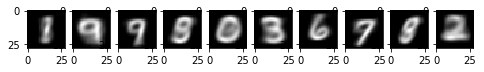

In [131]:
import tensorflow as tf
from sklearn.mixture import GaussianMixture as EM
import matplotlib.pyplot as plt

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("data/")

X = mnist.train.images
y = mnist.train.labels

# One cluster for each digit
k = 10

# Run EM algorithm on 1000 images from the MNIST dataset. 
expectation_maximization = EM(n_components=k, max_iter=10, init_params='kmeans', covariance_type='diag', verbose=1, verbose_interval =1).fit(X)

means = expectation_maximization.means_
covs = expectation_maximization.covariances_
      
fig, ax = plt.subplots(1, k, figsize=(8, 1))

for i in range(k):
    ax[i].imshow(means[i].reshape(28, 28), cmap='gray')
    
plt.show()


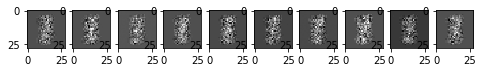

In [132]:
from scipy.stats import multivariate_normal
import numpy as np

def sample(means, covs, num):
    mean = means[num]
    cov = covs[num]
     
    fig, ax = plt.subplots(1, 10, figsize=(8, 1))
    
    for i in range(10):
        img = multivariate_normal.rvs(mean=mean, cov=cov) # draw random sample   
        ax[i].imshow(img.reshape(28, 28), cmap='gray') # draw the random sample
    plt.show()
    
sample(means, covs, 0)

<b>Report section 4: </b>
- Explain why we can generate images of "digits" using the Expectation Maximization algorithm. 
- (optional) Why does the sampled images look <a hrf="https://boofcv.org/images/1/18/Example_lena_denoise_noisy.jpg" target="new">noisy</a>?

## Deliverables
As part of the handin you must submit the following.

### Code
You must include a `.py` file including your implementations of the two algorithms (Lloyd and EM) and the two evaluation measures (Silhouette coefficient and F1 score). Alternatively, you could code everything in here and upload the final IPython Notebook. 

### Report
Your report should be no more than 5 pages and clearly state who is in the group. It must cover:

* Summary/Abstract: The status of the work, i.e., does it work, if not, then why.

<b>Report section 1: </b>
- Explain how you compared the results of Lloyd's algoithm and the Expectation Maximization algorithm. 
- Which algorithm performed best? 

<b>Report section 2.1: </b>
- Include a tabel that holds the silhouette coefficient for the above experiment.
- Which value of $k$ gave the best silhouette coefficient?

<b>Report section 2.2: </b>
- Include a tabel that holds the silhouette coefficient for the above experiment.
- Which value of $k$ gave the best silhouette coefficient?

<b>Report section 2.3: </b>Are there any differences between the two quality measures (F1 and Silhouette Coefficient)?

HINT: External/internal measures supervised/unsupervised.

<b>Report section 3: </b>
- Include the original and the compressed image. You should state the original and compressed sizes and the compression ratio. 
- Briefly in 5 lines write what you did to compress you image. 

<b>Report section 4: </b>
- Explain why we can generate images of digits using the Expectation Maximization algorithm. 
- (optional) Why does the sampled images look <a hrf="https://boofcv.org/images/1/18/Example_lena_denoise_noisy.jpg" target="new">noisy</a>?</div>

<!--
* A discussion of plots of at least two runs of your algorithm
  implementations detailing what you can see. Make sure that you relate this
  to the discussion in the lecture or textbook about the strengths and
  weaknesses of the algorithms.
* A discussion of plots of the evaluation measures F1 and silhouette
  coefficient, detailing what you can learn from them. Include an explanation
  of what the evaluation measures reflect. TODO: Compute for several k's?
* Describe how you can use one of the clustering algorithms for image
  compression, and demonstrate the results for at least one algorithm on both
  images, discussing their quality and giving a reasoning for the differences. -->
  
